In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import hashlib
import json
from pathlib import Path
from PIL import image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import pyjq
from tqdm import tqdm_notebook as tqdm
from fastai.vision import verify_images

In [3]:
dataroot = Path('../data').resolve()

## Image metadata

First, we download the metadata that describes selections from the newspaper images and their categories.

In [4]:
mfilepath = dataroot / 'metadata.json'

if not mfilepath.is_file(): # download only if data doesn't exist
    url = 'http://beyondwords.labs.loc.gov/data'
    with requests.get(url) as r:
        with open(mfilepath, 'wt', encoding='utf-8') as f:
            f.write(r.text)

In [5]:
with open(mfilepath) as f:
    mdata = json.load(f)

We'll use [pyjq](https://github.com/doloopwhile/pyjq), a Python wrapper for the mighty [jq](https://stedolan.github.io/jq/), to flatten the JSON and include only the values we're interested in. The flattened JSON will be much easier to work with.

One complication with this particular dataset is that the `category` key is sometimes found directly under the `data` key and sometimes a couple of levels deeper. We'll try to grab it in both locations give the results different names, `category1` and `category2`, and sort them out later. jq's `$` qualifier lets us reference keys that might be missing.

In [6]:
# use jq to grab the attributes we need
jqs = """
.data?[] | {
    reg_x: .region.x,
    reg_y: .region.y,
    reg_w: .region.width,
    reg_h: .region.height,
    category1: .data.category?,
    category2: .data?.values?[0].category?,
    img_w: .width,
    img_h: .height,
    img_url: .location.standard
}
"""
imgdata = pyjq.all(jqs, mdata)

Let's pull the modified JSON into a DataFrame and take a look.

In [7]:
mdf = pd.DataFrame(imgdata)

In [8]:
mdf.head(5)

,reg_x,reg_y,reg_w,reg_h,category1,category2,img_w,img_h,img_url
0,503.305527,2087.549874,2500.109304,2970.426698,Illustration,None,8936,12536,http://s3.amazonaws.com/ndnp-jpeg-surrogates/i...
1,972.575746,4640.102984,1787.148838,2780.009299,None,Photograph,6334,8362,http://s3.amazonaws.com/ndnp-jpeg-surrogates/d...
2,2466.295432,1936.944440,773.975688,1772.524726,None,Photograph,6268,8349,http://s3.amazonaws.com/ndnp-jpeg-surrogates/d...
3,1169.948708,1866.483282,1724.344889,2027.322461,None,Photograph,4208,5384,http://s3.amazonaws.com/ndnp-jpeg-surrogates/u...
4,4687.836735,2369.451019,924.290249,2134.548688,Photograph,None,6756,9297,http://s3.amazonaws.com/ndnp-jpeg-surrogates/u...


In [9]:
mdf.count()

reg_x        2173
reg_y        2173
reg_w        2173
reg_h        2173
category1    1368
category2     787
img_w        2173
img_h        2173
img_url      2173
dtype: int64

Looks good, but our categories are divided between `category1` and `category2`. Let's generate a new column `label` that contains the value from whichever column is not blank. We'll be calling the categories labels from now on out, since that's the usual lingo in deep learning.

In [10]:
mdf['label'] = mdf.apply(lambda x: x['category1'] if x['category1'] else x['category2'], axis=1)

In [11]:
mdf.drop(['category1', 'category2'], axis=1, inplace=True)

Each row in our data represents a selection from an image, which means that more than one row can refer to the same image. We need a way to give a unique identifier to each image so that we can group rows by image. An MD5 hash of the image url will work for this, since each image has one unique url and therefore one unique MD5 hash of the url.

In [12]:
# helper function to create MD5 hash from a string
def hash_str(s):
    return hashlib.md5(s.encode('utf-8')).hexdigest()

# add column that is the hash of the image url
mdf['img_url_hash'] = mdf.apply(lambda x: hash_str(x['img_url']), axis=1)

In [13]:
mdf['label'].value_counts(dropna=False)

Photograph           1392
Illustration          428
Comics/Cartoon        237
Editorial Cartoon      74
Map                    24
NaN                    18
Name: label, dtype: int64

In [14]:
mdf.head(3)

,reg_x,reg_y,reg_w,reg_h,img_w,img_h,img_url,label,img_url_hash
0,503.305527,2087.549874,2500.109304,2970.426698,8936,12536,http://s3.amazonaws.com/ndnp-jpeg-surrogates/i...,Illustration,92bd856d1492f988eb113bc44f271dc3
1,972.575746,4640.102984,1787.148838,2780.009299,6334,8362,http://s3.amazonaws.com/ndnp-jpeg-surrogates/d...,Photograph,74a406caa9af5c8d1d2e5a3333a27e82
2,2466.295432,1936.944440,773.975688,1772.524726,6268,8349,http://s3.amazonaws.com/ndnp-jpeg-surrogates/d...,Photograph,b509e86350b8a6469b425a4969dd3ff3


Now the dataset looks pretty good. We'll save it as a csv and move on.

In [15]:
# save image data as a csv
csvfilepath = dataroot / 'img_data.csv'
mdf.to_csv(csvfilepath, index=False, encoding='utf-8')

## Labels

We now have a dataset with one label per row, and we might need to look at multiple rows to find all the labels that apply to one image. For multi-image classification, we want to group all of the labels together in one row, so that each image is represented by one row that tells us all of the labels that apply.

We'll do this by grouping the rows by image identifier, then joining all of the labels in each group into a single string. While we're doing this, we'll clean up the label names a bit.

In [32]:
# helper function to join and clean up labels
def labelstr(obj):
    s = ' '.join(set(obj.astype(str)))
    s = s.replace('Editorial Cartoon', 'Ed_Cartoon')
    s = s.replace('Comics/Cartoon', 'Comic')
    s = s.lower().strip()
    return s

# group by image and apply our helper function to the labels
ldf = (
    mdf
    .groupby('img_url_hash')['label']
    .apply(lambda x: labelstr(x))
    .to_frame()
    .reset_index()
)

# rename columns
ldf.columns = ['id', 'labels']

In [33]:
ldf.count()

id        1327
labels    1327
dtype: int64

In [34]:
ldf['labels'].value_counts()

photograph                                       799
illustration                                     202
comic                                             99
illustration photograph                           85
ed_cartoon                                        44
comic photograph                                  24
map                                               18
illustration comic photograph                      6
none photograph                                    6
none                                               6
illustration ed_cartoon                            5
comic ed_cartoon                                   5
illustration comic                                 5
illustration comic ed_cartoon                      4
ed_cartoon photograph                              4
comic none                                         2
map photograph                                     2
comic ed_cartoon photograph                        1
map photograph ed_cartoon                     

For new, let's get rid of the items that have 'none' in the labels, since we're not sure what this means. 

In [38]:
ldf = ldf[~ldf['labels'].str.contains('none')]

In [39]:
ldf['labels'].value_counts()

photograph                            799
illustration                          202
comic                                  99
illustration photograph                85
ed_cartoon                             44
comic photograph                       24
map                                    18
illustration comic photograph           6
illustration comic                      5
illustration ed_cartoon                 5
comic ed_cartoon                        5
illustration comic ed_cartoon           4
ed_cartoon photograph                   4
map photograph                          2
illustration photograph ed_cartoon      1
illustration ed_cartoon photograph      1
comic ed_cartoon photograph             1
map photograph ed_cartoon               1
map illustration                        1
comic photograph ed_cartoon             1
map illustration photograph             1
photograph ed_cartoon                   1
Name: labels, dtype: int64

In [40]:
ldf.head()

,id,labels
0,0016af005540341d896923265a80c3b6,map
1,002d4d8d6a00aea0eb5c0db25feef011,photograph
2,00315cd56b0932d1a2511a5a5c408b79,illustration
3,004c143ad20bc6ec664eb9368b763e20,illustration photograph
4,006aed5b166ab85682ccdd7c86f80bd0,photograph


In [41]:
ldf.to_csv(dataroot / 'labels.csv', index=False)

## Get Images

Now, we'll download the images using the image urls in the metadata. Since we know images are referenced more than once, we won't download images that already have been downloaded. 

In [42]:
imgroot = dataroot / 'original_images'

In [43]:
for row in mdf.iterrows():
    url = row[1].img_url
    fname = row[1].img_url_hash + '.jpg'
    fpath = imgroot / fname
    if fpath.is_file():
        continue
    with requests.get(url, stream=True) as r:
        with open(fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk:
                    f.write(chunk)


Let's check the number of images that we've downloaded and take a look at their sizes.

In [23]:
len(list(imgroot.glob('*.jpg')))

1327

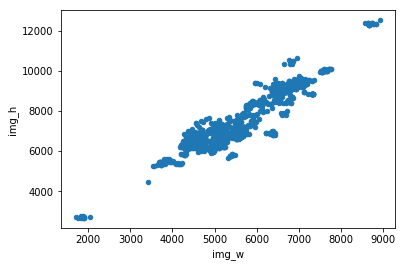

In [24]:
# show image sizes
_ = mdf.plot.scatter(x='img_w', y='img_h')

The original images are far bigger than we need for deep learning. We'll downsize them to a size just a little bit bigger than the maximum size we need. This will substantially decrease the overhead of resizing the images on the fly during training. It also means a quicker data uploads to our cloud GPU instance. 

Fastai's `verify_images` is intended for just this purpose, among other things. By default, it will also convert our one-channel grayscale images to three-channel RGB images, which our pretrained deep learning models will expect.

In [25]:
# suppress PIL warning for very large images
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

# resize as needed
imgoutroot = dataroot / 'images'
verify_images(imgroot, delete=False, max_size=600, dest=imgoutroot)

In [26]:
len(list(imgoutroot.glob('*.jpg')))

1327

In [27]:
# check for missing images -- original image names are the same as the resized ones 
orig_names = set([p.stem for p in imgoutroot.glob('*.jpg')])
new_names = set([p.stem for p in imgroot.glob('*.jpg')])
len(orig_names ^ new_names) == 0

True